In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

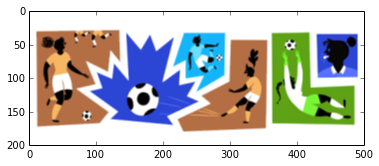

In [10]:
img = Image('/home/vagrant/notebooks/google.jpg')
img = img.blur()
img_d = img.getNumpyCv2()
im_shape = img_d.shape[0], img_d.shape[1]
plt.imshow(img_d)

In [11]:
# Make a function that does a half and half image.
def halfsies(left,right): 
    result = left
    # crop the right image to be just the right side.
    crop   = right.crop(right.width/2.0,0,right.width/2.0,right.height)
    # now paste the crop on the left image.
    result = result.blit(crop,(left.width/2,0))
    # return the results.
    return result

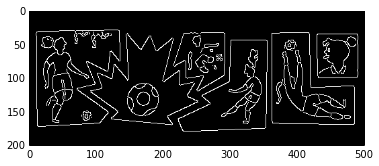

In [12]:
edges = img.edges(t1=160)
plt.imshow(edges.getNumpyCv2())

In [13]:
def unravel(d):
    n2d = d.shape[0] * d.shape[1]
    colors = np.empty((n2d, 3))
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            z = i * d.shape[1] + j
            colors[z] = d[i, j, :] * 255
    return pd.DataFrame(colors, columns=['R', 'G', 'B'])
colors = unravel(img_d)
colors.head()

,R,G,B
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


In [14]:
from sklearn import mixture
dpgmm = mixture.DPGMM(n_components=5)
dpgmm.fit(colors)
pred = dpgmm.predict(colors)
preds = pd.Series(pred)
preds.value_counts()

4    43264
2    19735
1    15343
3    15125
0     6533
dtype: int64

In [15]:
res = pd.concat([preds, colors], axis=1)
res = res.rename(columns={0: 'C'})
clusters = res.groupby('C').mean().applymap(lambda x: int(np.round(x)))
clusters.head()

,R,G,B
C,,,
0,163,94,236
1,133,139,183
2,167,124,29
3,77,146,189
4,1,1,1


In [16]:
merged = res.merge(clusters, left_on='C', right_index=True, suffixes=['', '_mean'])
merged.head()

,C,R,G,B,R_mean,G_mean,B_mean
0,4,1,1,1,1,1,1
1,4,1,1,1,1,1,1
2,4,1,1,1,1,1,1
3,4,1,1,1,1,1,1
4,4,1,1,1,1,1,1


In [17]:
def reravel(d, x, y):
    dc = np.empty((x, y, d.shape[1])) 
    for row in d.iterrows():
        i, r = row[0], row[1]
        r_i = int(i / float(dc.shape[1]))
        r_j = i % dc.shape[1]
        dc[r_i, r_j] = r 
    return dc

In [18]:
img_recon = reravel(merged[[c for c in merged.columns if 'mean' in c]], *im_shape[0:2])

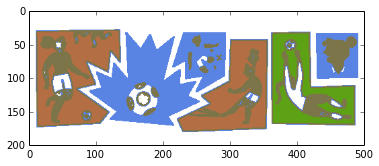

In [19]:
plt.imshow(img_recon)

In [20]:
img_cl = reravel(merged[['C']], img_d.shape[0], img_d.shape[1])
img_cl = np.reshape(img_cl, im_shape)
img_cl.shape

(200, 500)

In [40]:
x = {'z': 3}
x.items()[0]

('z', 3)

In [54]:
x = [1,2,3,4]
x.pop(-1)
x

[1, 2, 3]

In [55]:
# def visit(node, res, d, locs):
#     loc, value = node
#     locs.append(loc)
#     res[loc] = value
#     neighbors = [
#         (-1,-1), (-1,0), (-1,1),
#         (1, -1), (1, 0), (1, 1),
#         (0, -1), (0, 1)
#     ]
#     for offset in neighbors:
#         neighbor = get_neighbor(offset, loc, d)
#         if neighbor\
#             and not neighbor[0] in res.keys()\
#             and neighbor[1] == value:
#             visit(neighbor, res, d, locs)

def traverse(node, d, locs):
    res = {node[0]: node[1]}
    stack = [res.items()[0]]
    while len(stack) > 0:
        loc, value = stack.pop(-1)
        locs.append(loc)
        if len(locs) % 100 == 0:
            print 'loc len:', len(locs), ', stack len: ', len(stack)
        neighbors = [
            (-1,-1), (-1,0), (-1,1),
            (1, -1), (1, 0), (1, 1),
            (0, -1), (0, 1)
        ]
        for offset in neighbors:
            neighbor = get_neighbor(offset, loc, d)
            if neighbor\
                and not neighbor[0] in res.keys()\
                and neighbor[1] == value:
                res[neighbor[0]] = neighbor[1]
                stack.append(neighbor)
    return res

def get_neighbor(offset, loc, d):
    i, j = loc
    ni, nj = i + offset[0], j + offset[1]
    if ni < 0 or ni >= d.shape[0]:
        return None
    if nj < 0 or nj >= d.shape[1]:
        return None
    return (ni, nj), d[ni, nj]

def get_clusters(d, locs):
    candidates = dict([(i, v) for i, v in np.ndenumerate(d)])
    clusters = {}
    while len(candidates) > 0:
        print 'canidate len:', len(candidates)
        loc = candidates.keys()[0]
        val = candidates[loc]
        if not val in clusters.keys():
            clusters[val] = []
        res = traverse((loc, val), d, locs)
        clusters[val].append(res.keys())
        for k in res.keys():
            candidates.pop(k) 
    return clusters
    

In [56]:
locs = []
cls = get_clusters(img_cl, locs)
cls.shape

canidate len: 100000
loc len: 100 , stack len:  110
loc len: 200 , stack len:  210
loc len: 300 , stack len:  308
loc len: 400 , stack len:  408
loc len: 500 , stack len:  508
loc len: 600 , stack len:  608
loc len: 700 , stack len:  708
loc len: 800 , stack len:  808
loc len: 900 , stack len:  908
loc len: 1000 , stack len:  1008
loc len: 1100 , stack len:  1108
loc len: 1200 , stack len:  1208
loc len: 1300 , stack len:  1306
loc len: 1400 , stack len:  1402
loc len: 1500 , stack len:  1502
loc len: 1600 , stack len:  1600
loc len: 1700 , stack len:  1700
loc len: 1800 , stack len:  1800
loc len: 1900 , stack len:  1900
loc len: 2000 , stack len:  2000
loc len: 2100 , stack len:  2100
loc len: 2200 , stack len:  2200
loc len: 2300 , stack len:  2300
loc len: 2400 , stack len:  2400
loc len: 2500 , stack len:  2500
loc len: 2600 , stack len:  2598
loc len: 2700 , stack len:  2696
loc len: 2800 , stack len:  2794
loc len: 2900 , stack len:  2892
loc len: 3000 , stack len:  2992
loc len

AttributeError: 'dict' object has no attribute 'shape'

In [57]:
pd.Series(locs).value_counts().order(ascending=False).head()

(176, 465)    1
(134, 12)     1
(191, 232)    1
(9, 0)        1
(171, 86)     1
dtype: int64

In [58]:
len(locs)

100000